In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

## Data Loading

In [27]:
opportunities = pd.read_excel("shared_data_read_only/Opportunities.xlsx")
business = pd.read_excel("shared_data_read_only/Business Account.xlsx")
invoice = pd.read_excel("shared_data_read_only/Invoice and Opportunities.xlsx")

opportunities_b = opportunities.merge(business, on="Business Account", how='left')
opportunities_b = opportunities_b[['Opportunity ID', 'Business Account', 'Status',
       'Stage', 'Probability', 'Owner Name_x', 'Class ID', 'Agreement',
       'Created On_x', 'Last Modified Date', 'Branch ID', 'Estimated amount', 'Customer Status',
       'Type', 'Partner type', 'Class_y', 'Class Name', 'Activity sector', 'Owner Name_y',
       'Postal Code', 'City', 'Country Name',
       'Created On_y']]

## Incoherence dectected for the Amount between Invoice & Opportunities dataset and Opportunities dataset


In [28]:
print(opportunities[opportunities['Opportunity ID']==6241]['Amount received'])
print(invoice[invoice['Opportunity ID']==6241]['Amount'])

146    650.0
Name: Amount received, dtype: float64
14    1300.0
Name: Amount, dtype: float64


## Combine Status and Stage

In [29]:
opportunities_b.loc[opportunities_b.Status=="Lost", 'Probability'] = 0
opportunities_b.loc[opportunities_b.Status=="Won", 'Probability'] = 1
opportunities_b.loc[(opportunities_b.Status=="Open") & (opportunities_b.Stage=="Won"), 'Probability'] = 1
opportunities_b.loc[(opportunities_b.Status=="Open") & (opportunities_b.Stage=="Lost"), 'Probability'] = 0

opportunities_b.loc[(opportunities_b.Status=="Open") & (opportunities_b.Stage=="Initial Prospect"), 'Probability'] = 0.2
opportunities_b.loc[(opportunities_b.Status=="Open") & (opportunities_b.Stage=="Dossier posed"), 'Probability'] = 0.4
opportunities_b.loc[(opportunities_b.Status=="Open") & (opportunities_b.Stage=="Advanced Prospect"), 'Probability'] = 0.6
opportunities_b.loc[(opportunities_b.Status=="Open") & (opportunities_b.Stage=="Oral agreement"), 'Probability'] = 0.8
opportunities_b = opportunities_b.drop(['Status', 'Stage'], axis=1)
opportunities_b1 = opportunities_b

## Impute Data

In [30]:
for column in opportunities_b1.select_dtypes(exclude=['float64', 'int64']):
    opportunities_b1[column] = opportunities_b1[column].fillna(opportunities_b1[column].mode()[0])

In [31]:
column = "Owner Name_y"
opportunities_b1[column] = opportunities_b1[column].fillna(opportunities_b1[column].mode()[0])

column = "Owner Name_x"
opportunities_b1[column] = opportunities_b1[column].fillna(opportunities_b1[column].mode()[0])

amounts = opportunities_b1['Estimated amount']
opportunities = opportunities_b1.drop(['Estimated amount'], axis = 1)
opportunities = opportunities.copy()
#amounts = amounts.iloc[:, 0]

## split date to year, month, day

In [32]:
date_columns = ['Created On_x', 'Last Modified Date', 'Created On_y']
for col in date_columns:
    opportunities.loc[:, col] = pd.to_datetime(opportunities[col])
    opportunities.loc[:, col + '_year'] = opportunities[col].dt.year
    opportunities.loc[:, col + '_month'] = opportunities[col].dt.month
    opportunities.loc[:, col + '_day'] = opportunities[col].dt.day
    opportunities.drop(col, axis=1, inplace=True)

## encode categorical features

In [33]:
categorical_columns = ["Business Account", "Class ID", "Agreement", "Branch ID", "Customer Status", "Partner type",
                       "Class_y", "Class Name", "Activity sector", "City", "Country Name",  'Type', 'Postal Code']

label_encoders = {}
for col in categorical_columns:
    if opportunities[col].notnull().all():  # Only encode if there are no NaN values
        le = LabelEncoder()
        opportunities.loc[:, col] = le.fit_transform(opportunities[col])
        label_encoders[col] = le

## Overview of NA values

black -> presence of value 

<AxesSubplot:>

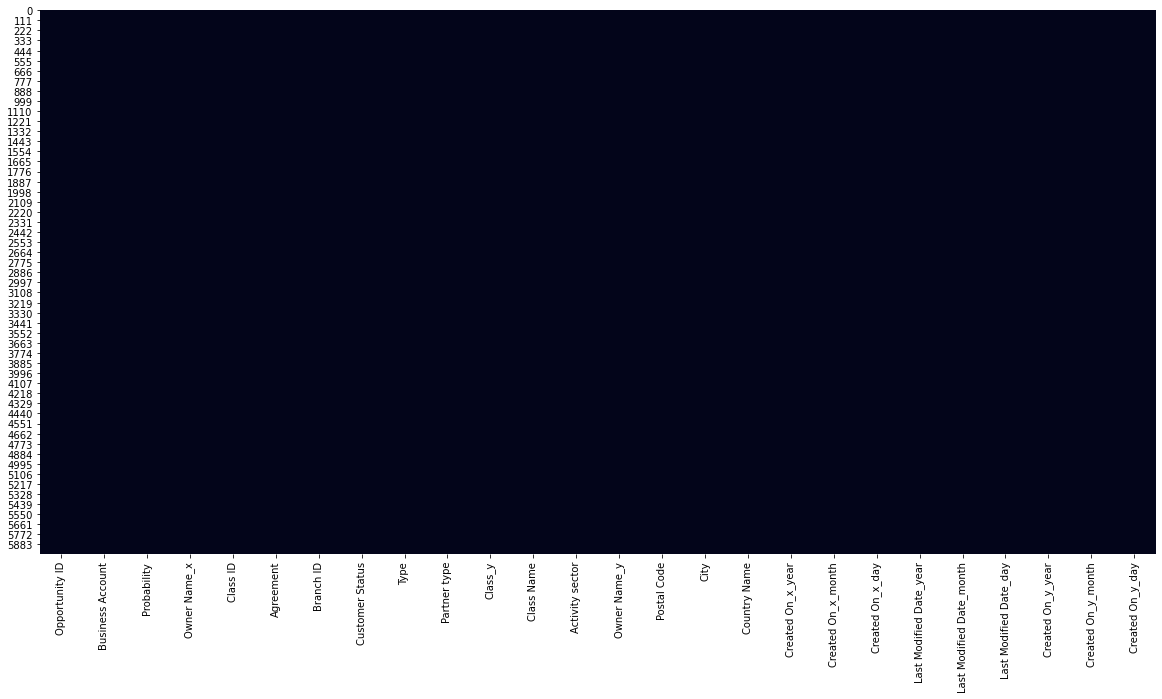

In [34]:
plt.figure(figsize=(20,10))
sns.heatmap(opportunities.isna(), cbar=False)

# Modeling

## Split Data for training and testing

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X = opportunities
y = amounts  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mae = []
mse = []

### Linear Regression

In [45]:
from sklearn.model_selection import train_test_split
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mae.append(mean_absolute_error(y_test, y_pred))
mse.append(mean_squared_error(y_test, y_pred))

### KNN Regressor

In [46]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors=5) 
knn_regressor.fit(X_train, y_train)
y_pred = knn_regressor.predict(X_test)

mae.append(mean_absolute_error(y_test, y_pred))
mse.append(mean_squared_error(y_test, y_pred))

### Random Forest Regressor

In [47]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)  
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

mae.append(mean_absolute_error(y_test, y_pred))
mse.append(mean_squared_error(y_test, y_pred))

### XGB Regressor

In [48]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, enablecategorical=True)
xgb_model.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_test, y_test)], verbose=True)
y_pred = xgb_model.predict(X_test)

mae.append(mean_absolute_error(y_test, y_pred))
mse.append(mean_squared_error(y_test, y_pred))

[17:17:33] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { enablecategorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:63644.57812
[1]	validation_0-rmse:60939.56641
[2]	validation_0-rmse:58913.68359
[3]	validation_0-rmse:57373.13672
[4]	validation_0-rmse:56680.70312
[5]	validation_0-rmse:55018.93750
[6]	validation_0-rmse:52881.28906
[7]	validation_0-rmse:52693.55469
[8]	validation_0-rmse:52862.74219
[9]	validation_0-rmse:52734.79297
[10]	validation_0-rmse:53062.63672
[11]	validation_0-rmse:51627.17969
[12]	validation_0-rmse:52251.66797
[13]	validation_0-rmse:51994.68359
[14]	validation_0-rmse:51088.44531
[15]	validation_0-rmse:51444.27344
[16]	validation_0-rmse:51631.86328
[17]	validation_0-rmse:51551

## Plot of metrics

The lower the metrics are the best the mode 

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


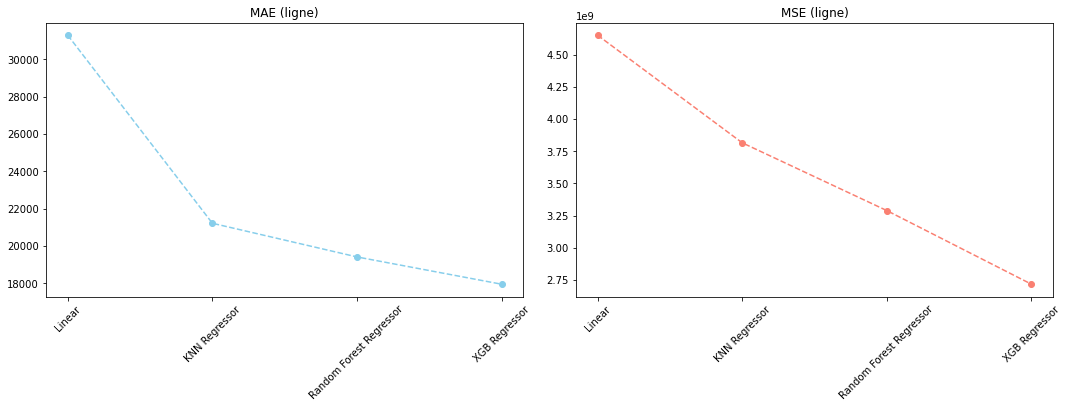

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

models = ['Linear', 'KNN Regressor', 'Random Forest Regressor', 'XGB Regressor'] 

# Sous-plot MAE 
axs[0].plot(models, mae, marker='o', color='skyblue', linestyle='--')
axs[0].set_xticklabels(models, rotation=45)
axs[0].set_title('MAE (ligne)')

# Sous-plot MSE 
axs[1].plot(models, mse, marker='o', color='salmon', linestyle='--')
axs[1].set_xticklabels(models, rotation=45)
axs[1].set_title('MSE (ligne)')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Feature Importance of XGB Regressor

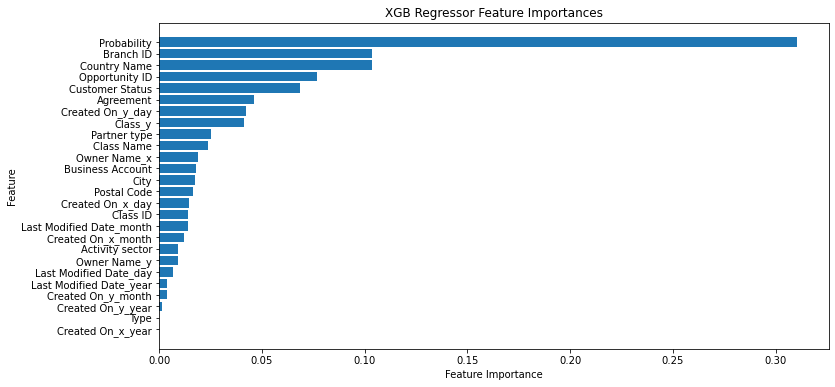

In [51]:
feature_importances = xgb_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGB Regressor Feature Importances')
plt.gca().invert_yaxis() 
plt.show()